In [1]:
import torch 
import torch_geometric
from molecular_mpns.proto_molecule import Molecule
from molecular_mpns.data import MarkovMolGraph
from molecular_mpns.config import data_dir,fig_dir
from molecular_mpns.modules import ProtoNet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tick

In [2]:
# set up molecular environment 
N = 5
beta = 15.0
kb = 1.0
rb = 2.0
ka = 1.0
ra = np.pi/2
kd = np.array([[0.02, 3], [0.02, 2]])
mol = Molecule(N, beta, kb, rb, ka, ra, kd)

In [3]:
# load data
data = np.load(str(data_dir)+'/proto_mol_traj.npy')

# training-validation partition
np.random.seed(42)
part = 1000000
n_train,n_val = 200000,200000

train,val = data[0:part],data[part:]
train_idx,val_idx = np.random.choice(train.shape[0],n_train),np.random.choice(val.shape[0],n_val)


In [4]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

emb_dim = 64
intermediate_dim = 32
n_rbf = 32
rbf_range = [2,5]
gamma = 2

reg_proj = (beta/2)
reg_norm = (beta/4)
dt = 5e-3

mod = ProtoNet(emb_dim,intermediate_dim,n_rbf,rbf_range,gamma)
mod = mod.double()
mod = mod.to(device)

opt = torch.optim.SGD(mod.parameters(),lr = 1e-3)

Epoch 1 Loss:-3.22539924261005


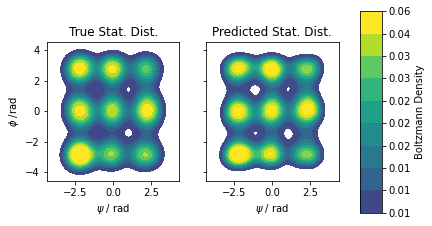

In [5]:
# train
np.random.seed(42)
part = 1000000
n_train,n_val = 10000,10000
train,val = data[0:part],data[part:]
val_idx = np.random.choice(val.shape[0],n_val)

val_set = val[val_idx]

epochs = 1
bs = 32
Z = np.array([[0],[0],[0],[0],[0]])

for ep in range(epochs):
    ep_loss = 0.0
    loss = 0.0
    train_idx= np.random.choice(train.shape[0],n_train)
    
    for i,idx in enumerate(train_idx):
        
        if (idx+1) != part:
            r_current,r_next = train[idx],train[idx+1]
        else:
            r_current,r_next = data[idx],data[idx+1]
            
        g = MarkovMolGraph(r_current=r_current,r_next = r_next, Z = Z)
        g.to(device)
        
        V = mod(g)
        
        dx = g.r_next - g.r_current
        b = -1*torch.autograd.grad(V,g.r_current,create_graph = True)[0]
        
        loss += -reg_proj*((b*dx).sum()) + reg_norm*((b*b).sum())*dt
        
        if (i+1)%bs == 0:
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_loss += loss.item()
            loss = 0.0
    
    print('Epoch ' + str(ep+1) + ' Loss:' + str(ep_loss))
    
    # validate
    with torch.no_grad():
        IC,V,V_pred = np.zeros((n_val,9)),np.zeros(n_val),np.zeros(n_val)
        for i,x in enumerate(val_set):
            v,ic = mol._potential(x),mol._internal_coordinates(x)
            V[i],IC[i,:] = v,ic
            
            g = MarkovMolGraph(r_current=x,r_next = x, Z = Z)
            g.to(device)
            v_pred = mod(g)
            V_pred[i] = v_pred.cpu().numpy()
            
        phi,psi = IC[:,7],IC[:,8]
        fig,ax = plt.subplots(1,2,sharey = True)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        formatter=tick.FormatStrFormatter('%.2f')
        cbar_kws = {'label': 'Boltzmann Density','format':formatter}
            
        sns.kdeplot(ax = ax[0],x=phi,y=psi,weights = np.exp(-beta*V),fill = True,cmap = 'viridis',vmin = 0,vmax = 0.04,cbar = True,cbar_ax = cbar_ax,cbar_kws = cbar_kws)
        ax[0].set_aspect('equal')
        ax[0].set_title('True Stat. Dist.')
        ax[0].set_xlabel('$\psi$ / rad')
        ax[0].set_ylabel('$\phi$ /rad')
        
      
        im=sns.kdeplot(ax = ax[1],x=phi,y=psi,weights = np.exp(-beta*V_pred),fill = True,cmap = 'viridis',vmin = 0,vmax = 0.04) 
        ax[1].set_aspect('equal')
        ax[1].set_title('Predicted Stat. Dist.')
        ax[1].set_xlabel('$\psi$ / rad')
    
        fig.subplots_adjust(right=0.8)
        plt.savefig(str(fig_dir)+'/proto_da_poten.png')
        plt.show()
        plt.close()